In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
dataframe = pd.read_csv("./train.csv")
dataset = dataframe.values
print dataset.shape

(990, 193)


In [3]:
Y = dataset[:,0]
X = dataset[:,1:].astype(float)

In [4]:
encoder=LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
dummy_y = np_utils.to_categorical(encoded_Y)

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X,dummy_y, test_size=0.2, random_state=0)

In [59]:
def modelBN(sgd):
    model = Sequential()
    model.add(Dense(192, input_dim=192, init='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(100, init='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(100, init='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dense(100, init='uniform'))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    model.add(Dense(output_dim=99, init='uniform'))
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_crossentropy'])
    return model

def modelNBN(sgd):
    model = Sequential()
    model.add(Dense(192, input_dim=192, init='uniform'))
    model.add(Activation('relu'))
    model.add(Dense(100, init='uniform'))
    model.add(Activation('relu'))
    model.add(Dense(100, init='uniform'))
    model.add(Activation('relu'))
    model.add(Dense(100, init='uniform'))
    model.add(Activation('softmax'))
    model.add(Dense(output_dim=99, init='uniform'))
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['categorical_crossentropy'])
    return model

In [61]:
%%time
bnModelScores=[]

alphaList=[]

for i in range (0,7):
    alpha = 0.001*(10**i)
    sgd = SGD(lr=alpha, decay=1e-6, momentum=0.9, nesterov=True)
    
    model1 = modelBN(sgd)
    model1.fit(X_train,y_train,validation_data=(X_test,y_test), nb_epoch=100,batch_size=20,verbose=0)
    bnscore=model1.evaluate(X_test,y_test,batch_size=198)[1]
    bnModelScores.append(bnscore)
    alphaList.append(alpha)

198/198 [==============================] - 0s
CPU times: user 6min 47s, sys: 27.4 s, total: 7min 14s
Wall time: 3min 56s


In [68]:
model1.weights

In [62]:
%%time
alphaList=[]
nbnModelScores=[]
for i in range (0,7):
    alpha = 0.001*(10**i)
    sgd = SGD(lr=alpha, decay=1e-6, momentum=0.9, nesterov=True)
    
    model2 = modelNBN(sgd)
    model2.fit(X_train,y_train,nb_epoch=100,batch_size=20,verbose=0)
    nbnscore=model2.evaluate(X_test,y_test,batch_size=198)[1]
    nbnModelScores.append(nbnscore)
    alphaList.append(alpha)

198/198 [==============================] - 2s
CPU times: user 4min 35s, sys: 16.9 s, total: 4min 52s
Wall time: 3min 5s


In [37]:
print alphaList

[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]


In [43]:
print nbnModelScores

[4.813908576965332, 4.7122039794921875, 4.6307744979858398, 4.5973691940307617, 4.6836543083190918, 4.5730361938476562, 4.7059111595153809]


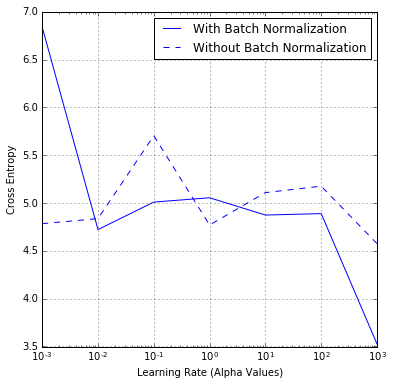

In [69]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.semilogx(alphaList,bnModelScores,basex=10)
ax.semilogx(alphaList,nbnModelScores,'--',color='b',basex=10)
plt.xlabel('Learning Rate (Alpha Values)')
plt.ylabel('Cross Entropy')
plt.legend(['With Batch Normalization','Without Batch Normalization'],loc=1)
plt.grid()
plt.savefig("alpha2.png")